# Resultados - Modelos de Classificação

Este notebook apresenta os resultados e comparações dos modelos de classificação treinados.

**Modelos avaliados:**
- Logistic Regression
- Random Forest Classifier
- Gradient Boosting Classifier

---

## 1. Configuração e Importações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, 
    classification_report, roc_curve
)
import warnings
warnings.filterwarnings('ignore')

# Configuração de visualização
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Bibliotecas carregadas com sucesso!")

Bibliotecas carregadas com sucesso!


## 2. Carregar Modelos Salvos

In [2]:
# Carregar modelos
models_path = '../models'

models = {}
model_files = {
    'Logistic Regression': 'logistic_regression_best.pkl',
    'Random Forest': 'random_forest_best.pkl',
    'Gradient Boosting': 'gradient_boosting_best.pkl'
}

print("Carregando modelos salvos...")
print("="*60)

for name, filename in model_files.items():
    filepath = os.path.join(models_path, filename)
    if os.path.exists(filepath):
        models[name] = joblib.load(filepath)
        print(f"✓ {name}: carregado com sucesso")
    else:
        print(f"✗ {name}: arquivo não encontrado ({filepath})")

# Carregar scaler e feature names
scaler = joblib.load(os.path.join(models_path, 'scaler.pkl'))
feature_names = joblib.load(os.path.join(models_path, 'feature_names.pkl'))

print(f"\n✓ Scaler carregado")
print(f"✓ {len(feature_names)} features carregadas")
print(f"\nModelos disponíveis: {len(models)}")

Carregando modelos salvos...
✓ Logistic Regression: carregado com sucesso
✓ Random Forest: carregado com sucesso
✓ Gradient Boosting: carregado com sucesso

✓ Scaler carregado
✓ 20 features carregadas

Modelos disponíveis: 3


## 3. Preparar Dados de Teste

In [3]:
# Carregar e preparar dados (mesmo processo do treinamento)
print("Preparando dados de teste...")

df_flights = pd.read_csv('../data/flights_clean.csv')
df = df_flights[df_flights['CANCELLED'] == 0].copy()

# Criar target
df['TARGET'] = (df['DEPARTURE_DELAY'] > 15).astype(int)

# Remover colunas de leakage
cols_leakage = [
    'YEAR', 'DAY', 'FLIGHT_NUMBER', 'TAIL_NUMBER',
    'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
    'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME',
    'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL',
    'ARRIVAL_TIME', 'ARRIVAL_DELAY',
    'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
    'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
    'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'
]
df = df.drop(columns=[col for col in cols_leakage if col in df.columns])

# Feature Engineering
df['HOUR'] = (df['SCHEDULED_DEPARTURE'] // 100).clip(0, 23)

def get_period(hour):
    if 6 <= hour < 12: return 'morning'
    elif 12 <= hour < 18: return 'afternoon'
    elif 18 <= hour < 24: return 'evening'
    else: return 'night'

df['PERIOD_OF_DAY'] = df['HOUR'].apply(get_period)
df['IS_WEEKEND'] = (df['DAY_OF_WEEK'].isin([6, 7])).astype(int)
df['MONTH_SIN'] = np.sin(2 * np.pi * df['MONTH'] / 12)
df['MONTH_COS'] = np.cos(2 * np.pi * df['MONTH'] / 12)
df['DAY_SIN'] = np.sin(2 * np.pi * df['DAY_OF_WEEK'] / 7)
df['DAY_COS'] = np.cos(2 * np.pi * df['DAY_OF_WEEK'] / 7)

origin_delay = df.groupby('ORIGIN_AIRPORT')['TARGET'].mean().to_dict()
df['ORIGIN_DELAY_RATE'] = df['ORIGIN_AIRPORT'].map(origin_delay)
origin_volume = df['ORIGIN_AIRPORT'].value_counts().to_dict()
df['ORIGIN_VOLUME'] = df['ORIGIN_AIRPORT'].map(origin_volume)
airline_delay = df.groupby('AIRLINE')['TARGET'].mean().to_dict()
df['AIRLINE_DELAY_RATE'] = df['AIRLINE'].map(airline_delay)

df = df.drop(columns=['SCHEDULED_DEPARTURE'])

# Encoding
df['ORIGIN_AIRPORT'] = df['ORIGIN_AIRPORT'].astype(str)
df['DESTINATION_AIRPORT'] = df['DESTINATION_AIRPORT'].astype(str)

le_airline = LabelEncoder()
df['AIRLINE_ENCODED'] = le_airline.fit_transform(df['AIRLINE'])

le_origin = LabelEncoder()
df['ORIGIN_ENCODED'] = le_origin.fit_transform(df['ORIGIN_AIRPORT'])

le_dest = LabelEncoder()
df['DEST_ENCODED'] = le_dest.fit_transform(df['DESTINATION_AIRPORT'])

origin_freq = df['ORIGIN_AIRPORT'].value_counts(normalize=True).to_dict()
df['ORIGIN_FREQ'] = df['ORIGIN_AIRPORT'].map(origin_freq)
dest_freq = df['DESTINATION_AIRPORT'].value_counts(normalize=True).to_dict()
df['DEST_FREQ'] = df['DESTINATION_AIRPORT'].map(dest_freq)

df = pd.get_dummies(df, columns=['PERIOD_OF_DAY'], prefix='PERIOD', drop_first=True)
df = df.drop(columns=['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'])

# Separar features e target
X = df.drop(columns=['TARGET'])
y = df['TARGET']

# Usar mesmo split do treinamento
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

# Normalizar
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Dados preparados")
print(f"  - Validação: {X_val.shape[0]:,} registros")
print(f"  - Teste: {X_test.shape[0]:,} registros")

Preparando dados de teste...

✓ Dados preparados
  - Validação: 857,088 registros
  - Teste: 859,380 registros


## 4. Avaliação dos Modelos

In [4]:
def evaluate_model(model, X, y, dataset_name=""):
    """Avalia um modelo e retorna métricas."""
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    return {
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred),
        'Recall': recall_score(y, y_pred),
        'F1-Score': f1_score(y, y_pred),
        'ROC-AUC': roc_auc_score(y, y_pred_proba)
    }

# Avaliar todos os modelos
results_val = []
results_test = []

print("Avaliando modelos...")
print("="*80)

for name, model in models.items():
    # Validação
    metrics_val = evaluate_model(model, X_val_scaled, y_val)
    metrics_val['Modelo'] = name
    results_val.append(metrics_val)
    
    # Teste
    metrics_test = evaluate_model(model, X_test_scaled, y_test)
    metrics_test['Modelo'] = name
    results_test.append(metrics_test)
    
    print(f"\n{name}:")
    print(f"  Validação - F1: {metrics_val['F1-Score']:.4f}, AUC: {metrics_val['ROC-AUC']:.4f}")
    print(f"  Teste     - F1: {metrics_test['F1-Score']:.4f}, AUC: {metrics_test['ROC-AUC']:.4f}")

Avaliando modelos...

Logistic Regression:
  Validação - F1: 0.3637, AUC: 0.6575
  Teste     - F1: 0.3635, AUC: 0.6571

Random Forest:
  Validação - F1: 0.3933, AUC: 0.7003
  Teste     - F1: 0.3938, AUC: 0.7012

Gradient Boosting:
  Validação - F1: 0.0399, AUC: 0.6978
  Teste     - F1: 0.0393, AUC: 0.6973


## 5. Comparação dos Modelos

In [5]:
# Criar DataFrames de comparação
df_val = pd.DataFrame(results_val)
df_test = pd.DataFrame(results_test)

# Reordenar colunas
cols_order = ['Modelo', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
df_val = df_val[cols_order].sort_values('F1-Score', ascending=False)
df_test = df_test[cols_order].sort_values('F1-Score', ascending=False)

print("RESULTADOS NO CONJUNTO DE VALIDAÇÃO")
print("="*80)
print(df_val.to_string(index=False))

print("\n\nRESULTADOS NO CONJUNTO DE TESTE")
print("="*80)
print(df_test.to_string(index=False))

RESULTADOS NO CONJUNTO DE VALIDAÇÃO
             Modelo  Accuracy  Precision   Recall  F1-Score  ROC-AUC
      Random Forest  0.695840   0.304371 0.555631  0.393297 0.700342
Logistic Regression  0.594378   0.252000 0.653412  0.363723 0.657527
  Gradient Boosting  0.823504   0.573071 0.020654  0.039872 0.697751


RESULTADOS NO CONJUNTO DE TESTE
             Modelo  Accuracy  Precision   Recall  F1-Score  ROC-AUC
      Random Forest  0.696388   0.304907 0.555722  0.393767 0.701245
Logistic Regression  0.594061   0.251790 0.653222  0.363476 0.657055
  Gradient Boosting  0.823460   0.570482 0.020330  0.039262 0.697328


In [6]:
# Identificar melhor modelo
best_model_name = df_test.iloc[0]['Modelo']
best_model = models[best_model_name]

print(f"\n{'='*80}")
print(f"MELHOR MODELO: {best_model_name}")
print(f"{'='*80}")

# Classification Report detalhado
y_test_pred = best_model.predict(X_test_scaled)
print("\nClassification Report (Conjunto de Teste):")
print(classification_report(y_test, y_test_pred, target_names=['Sem Atraso', 'Com Atraso']))


MELHOR MODELO: Random Forest

Classification Report (Conjunto de Teste):
              precision    recall  f1-score   support

  Sem Atraso       0.88      0.73      0.80    706899
  Com Atraso       0.30      0.56      0.39    152481

    accuracy                           0.70    859380
   macro avg       0.59      0.64      0.60    859380
weighted avg       0.78      0.70      0.73    859380



## 6. Visualizações

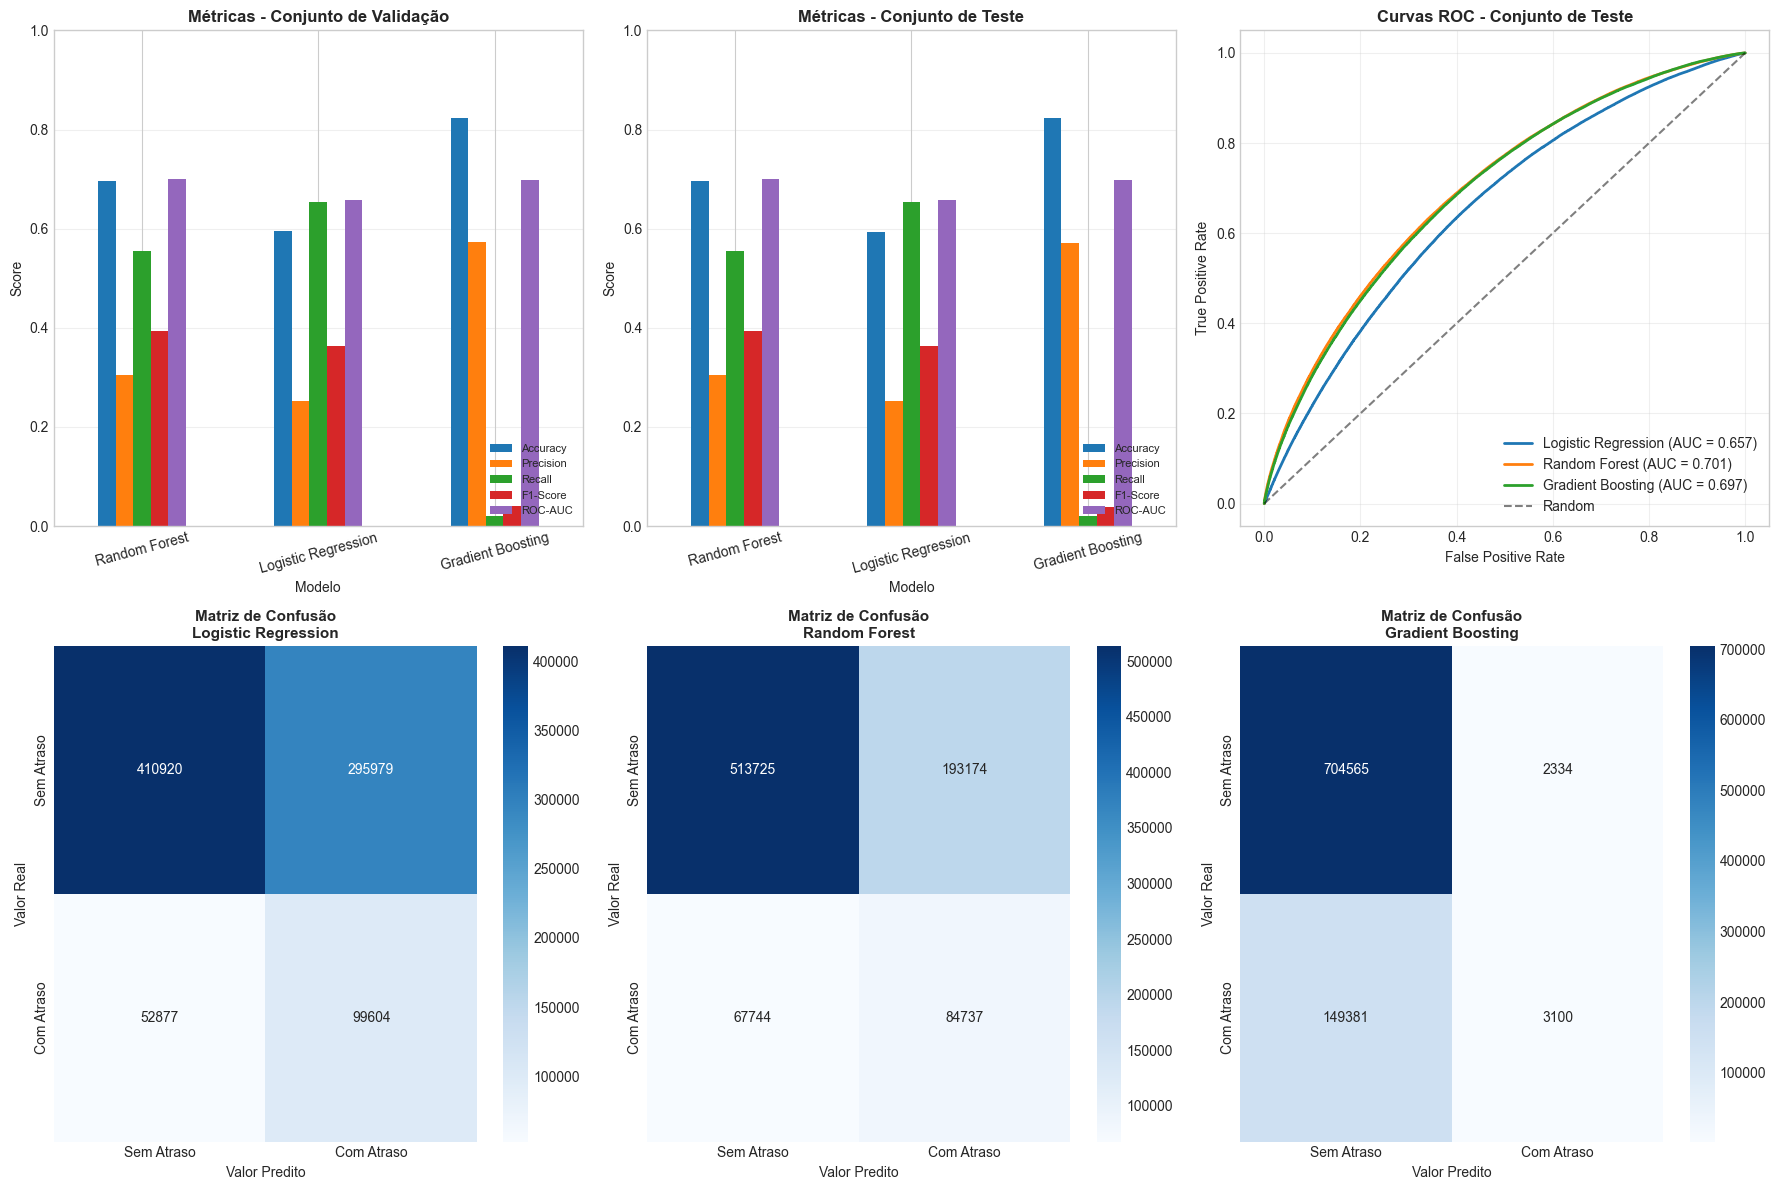


Visualização salva em: visualizacoes/classification_comparison.png


In [7]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Comparação de Métricas - Validação
ax1 = axes[0, 0]
metrics_cols = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
df_val.set_index('Modelo')[metrics_cols].plot(kind='bar', ax=ax1, rot=15)
ax1.set_title('Métricas - Conjunto de Validação', fontsize=12, fontweight='bold')
ax1.set_ylabel('Score')
ax1.set_ylim([0, 1])
ax1.legend(loc='lower right', fontsize=8)
ax1.grid(True, alpha=0.3, axis='y')

# 2. Comparação de Métricas - Teste
ax2 = axes[0, 1]
df_test.set_index('Modelo')[metrics_cols].plot(kind='bar', ax=ax2, rot=15)
ax2.set_title('Métricas - Conjunto de Teste', fontsize=12, fontweight='bold')
ax2.set_ylabel('Score')
ax2.set_ylim([0, 1])
ax2.legend(loc='lower right', fontsize=8)
ax2.grid(True, alpha=0.3, axis='y')

# 3. Curvas ROC
ax3 = axes[0, 2]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for (name, model), color in zip(models.items(), colors):
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    ax3.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', color=color, linewidth=2)

ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('Curvas ROC - Conjunto de Teste', fontsize=12, fontweight='bold')
ax3.legend(loc='lower right')
ax3.grid(True, alpha=0.3)

# 4, 5, 6. Matrizes de Confusão
for idx, (name, model) in enumerate(models.items()):
    ax = axes[1, idx]
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Sem Atraso', 'Com Atraso'],
                yticklabels=['Sem Atraso', 'Com Atraso'])
    ax.set_title(f'Matriz de Confusão\n{name}', fontsize=11, fontweight='bold')
    ax.set_ylabel('Valor Real')
    ax.set_xlabel('Valor Predito')

plt.tight_layout()
plt.savefig('visualizacoes/classification_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualização salva em: visualizacoes/classification_comparison.png")

## 7. Feature Importance

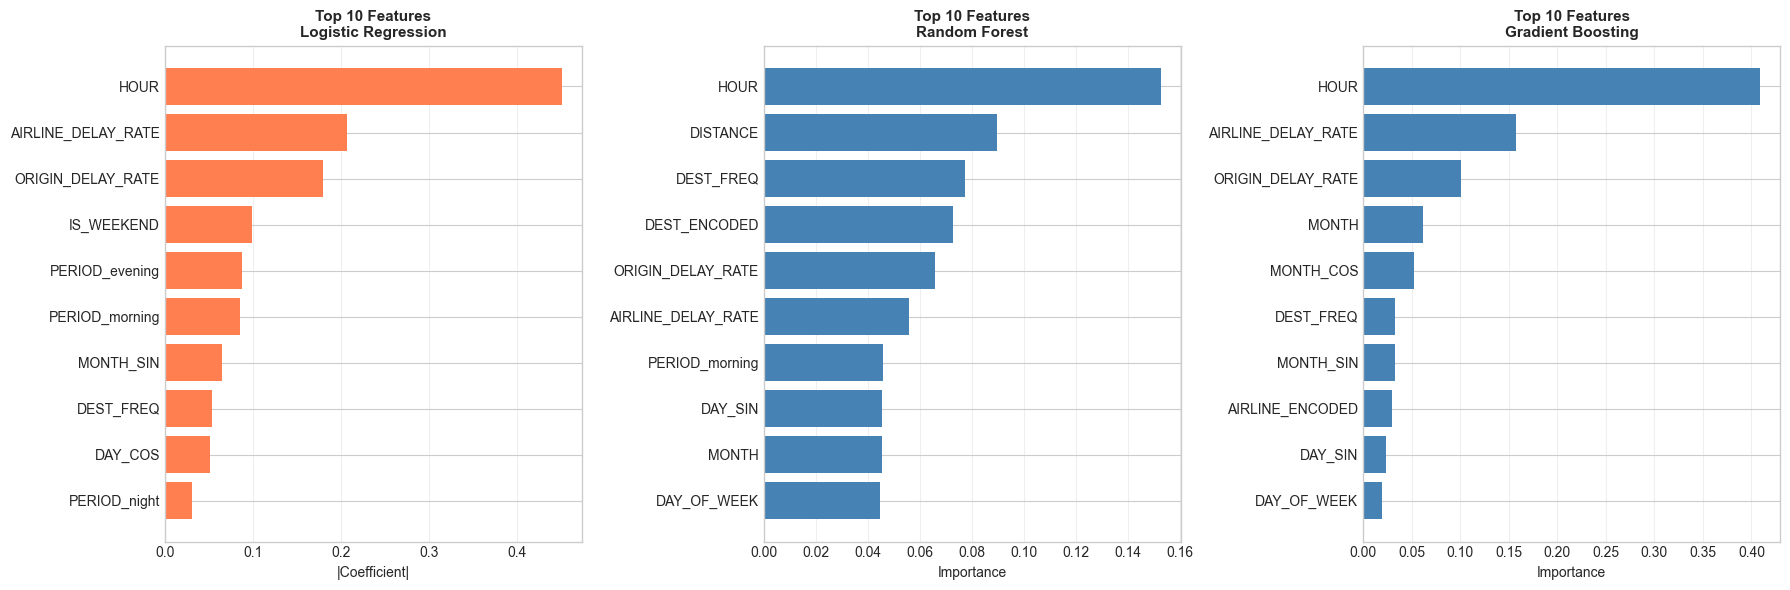


Visualização salva em: visualizacoes/feature_importance_comparison.png


In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (name, model) in enumerate(models.items()):
    ax = axes[idx]
    
    if hasattr(model, 'feature_importances_'):
        # Random Forest e Gradient Boosting
        importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=True).tail(10)
        
        ax.barh(importance['Feature'], importance['Importance'], color='steelblue')
        ax.set_xlabel('Importance')
    else:
        # Logistic Regression - usar coeficientes
        coef = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': np.abs(model.coef_[0])
        }).sort_values('Coefficient', ascending=True).tail(10)
        
        ax.barh(coef['Feature'], coef['Coefficient'], color='coral')
        ax.set_xlabel('|Coefficient|')
    
    ax.set_title(f'Top 10 Features\n{name}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('visualizacoes/feature_importance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualização salva em: visualizacoes/feature_importance_comparison.png")

## 8. Análise de Erros

In [9]:
# Análise de erros do melhor modelo
y_test_pred = best_model.predict(X_test_scaled)
y_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Criar DataFrame com resultados
df_errors = pd.DataFrame({
    'Real': y_test.values,
    'Predito': y_test_pred,
    'Probabilidade': y_test_proba
})

df_errors['Tipo'] = 'Correto'
df_errors.loc[(df_errors['Real'] == 0) & (df_errors['Predito'] == 1), 'Tipo'] = 'Falso Positivo'
df_errors.loc[(df_errors['Real'] == 1) & (df_errors['Predito'] == 0), 'Tipo'] = 'Falso Negativo'

print(f"Análise de Erros - {best_model_name}")
print("="*60)
print(f"\nDistribuição:")
print(df_errors['Tipo'].value_counts())

print(f"\nTaxa de erro:")
total = len(df_errors)
fp = (df_errors['Tipo'] == 'Falso Positivo').sum()
fn = (df_errors['Tipo'] == 'Falso Negativo').sum()
print(f"  - Falso Positivo: {fp:,} ({fp/total*100:.2f}%)")
print(f"  - Falso Negativo: {fn:,} ({fn/total*100:.2f}%)")

Análise de Erros - Random Forest

Distribuição:
Tipo
Correto           598462
Falso Positivo    193174
Falso Negativo     67744
Name: count, dtype: int64

Taxa de erro:
  - Falso Positivo: 193,174 (22.48%)
  - Falso Negativo: 67,744 (7.88%)


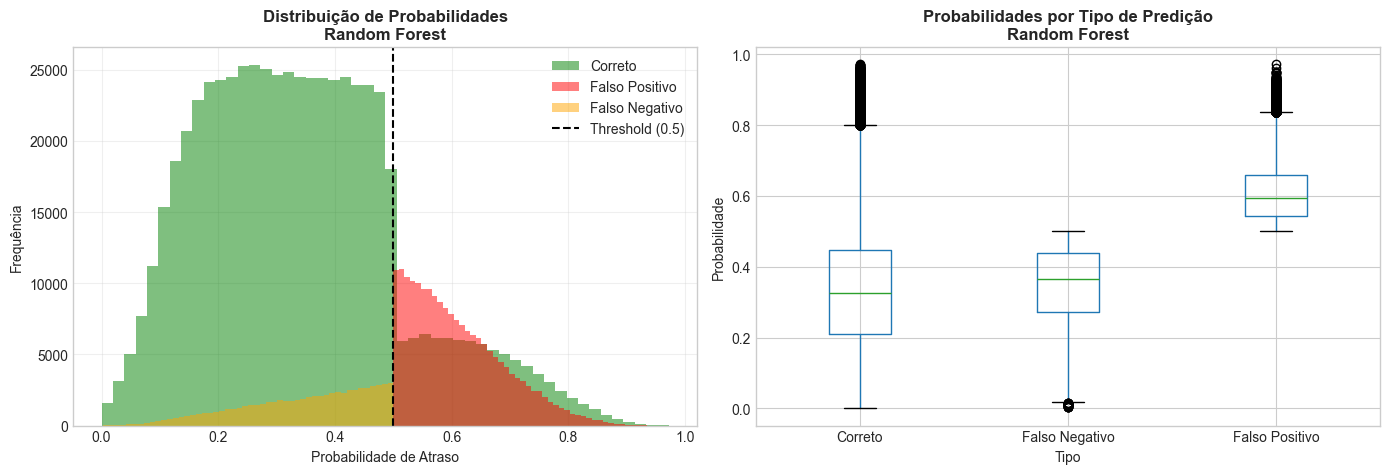

In [10]:
# Distribuição de probabilidades por tipo
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Distribuição de probabilidades
ax1 = axes[0]
for tipo, color in [('Correto', 'green'), ('Falso Positivo', 'red'), ('Falso Negativo', 'orange')]:
    data = df_errors[df_errors['Tipo'] == tipo]['Probabilidade']
    if len(data) > 0:
        ax1.hist(data, bins=50, alpha=0.5, label=tipo, color=color)

ax1.axvline(x=0.5, color='black', linestyle='--', label='Threshold (0.5)')
ax1.set_xlabel('Probabilidade de Atraso')
ax1.set_ylabel('Frequência')
ax1.set_title(f'Distribuição de Probabilidades\n{best_model_name}', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Boxplot de probabilidades
ax2 = axes[1]
df_errors.boxplot(column='Probabilidade', by='Tipo', ax=ax2)
ax2.set_title(f'Probabilidades por Tipo de Predição\n{best_model_name}', fontweight='bold')
ax2.set_xlabel('Tipo')
ax2.set_ylabel('Probabilidade')
plt.suptitle('')  # Remove título automático do boxplot

plt.tight_layout()
plt.savefig('visualizacoes/error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Resumo Final

In [11]:
print("="*80)
print("RESUMO FINAL - MODELOS DE CLASSIFICAÇÃO")
print("="*80)

print(f"\n1. OBJETIVO:")
print(f"   Prever se um voo terá atraso > 15 minutos na partida")

print(f"\n2. DADOS:")
print(f"   - Registros de teste: {len(y_test):,}")
print(f"   - Features: {len(feature_names)}")
print(f"   - Taxa de atraso (classe 1): {y_test.mean()*100:.2f}%")

print(f"\n3. RANKING DOS MODELOS (por F1-Score no Teste):")
for i, row in df_test.iterrows():
    print(f"   {df_test.index.get_loc(i)+1}. {row['Modelo']}:")
    print(f"      F1={row['F1-Score']:.4f}, AUC={row['ROC-AUC']:.4f}, Acc={row['Accuracy']:.4f}")

print(f"\n4. MELHOR MODELO: {best_model_name}")
best_metrics = df_test[df_test['Modelo'] == best_model_name].iloc[0]
print(f"   - Accuracy:  {best_metrics['Accuracy']:.4f}")
print(f"   - Precision: {best_metrics['Precision']:.4f}")
print(f"   - Recall:    {best_metrics['Recall']:.4f}")
print(f"   - F1-Score:  {best_metrics['F1-Score']:.4f}")
print(f"   - ROC-AUC:   {best_metrics['ROC-AUC']:.4f}")

print(f"\n5. ARQUIVOS SALVOS:")
print(f"   - ../models/logistic_regression_best.pkl")
print(f"   - ../models/random_forest_best.pkl")
print(f"   - ../models/gradient_boosting_best.pkl")
print(f"   - ../models/scaler.pkl")
print(f"   - ../models/feature_names.pkl")

print("\n" + "="*80)

RESUMO FINAL - MODELOS DE CLASSIFICAÇÃO

1. OBJETIVO:
   Prever se um voo terá atraso > 15 minutos na partida

2. DADOS:
   - Registros de teste: 859,380
   - Features: 20
   - Taxa de atraso (classe 1): 17.74%

3. RANKING DOS MODELOS (por F1-Score no Teste):
   1. Random Forest:
      F1=0.3938, AUC=0.7012, Acc=0.6964
   2. Logistic Regression:
      F1=0.3635, AUC=0.6571, Acc=0.5941
   3. Gradient Boosting:
      F1=0.0393, AUC=0.6973, Acc=0.8235

4. MELHOR MODELO: Random Forest
   - Accuracy:  0.6964
   - Precision: 0.3049
   - Recall:    0.5557
   - F1-Score:  0.3938
   - ROC-AUC:   0.7012

5. ARQUIVOS SALVOS:
   - ../models/logistic_regression_best.pkl
   - ../models/random_forest_best.pkl
   - ../models/gradient_boosting_best.pkl
   - ../models/scaler.pkl
   - ../models/feature_names.pkl

